## Para gerar as as imagem execute data.py que está na pasta data_pendulo


## As funções uteis estão no arquivo fuction.py

In [1]:
from fuction import *

Epoch [1/2000], Loss: 0.1487
Epoch [201/2000], Loss: 0.0206
Epoch [401/2000], Loss: 0.0199
Epoch [601/2000], Loss: 0.0167
Epoch [801/2000], Loss: 0.0176
Epoch [1001/2000], Loss: 0.0137
Epoch [1201/2000], Loss: 0.0145
Epoch [1401/2000], Loss: 0.0172
Epoch [1601/2000], Loss: 0.0137
Epoch [1801/2000], Loss: 0.0100
Treinamento concluído


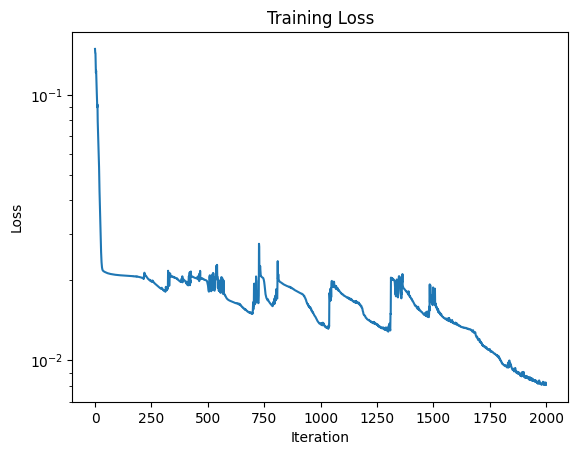

In [2]:
# Caminho para o diretório das imagens
root_dir = 'data_pendulo'  # Ajuste para o diretório onde suas imagens estão salvas

# DataLoader

train_dataset = CustomImageDataset(root_dir=root_dir)
test_dataset  = CustomImageDataset(root_dir=root_dir, split='test')
model         = SimpleAutoencoder(neck=1)  # Ajuste o parâmetro 'neck' conforme necessário
trainer       = Trainer(model, train_dataset,test_dataset, batch_size=30,step_size=300,device="cuda")
trainer.train(epochs=2000)

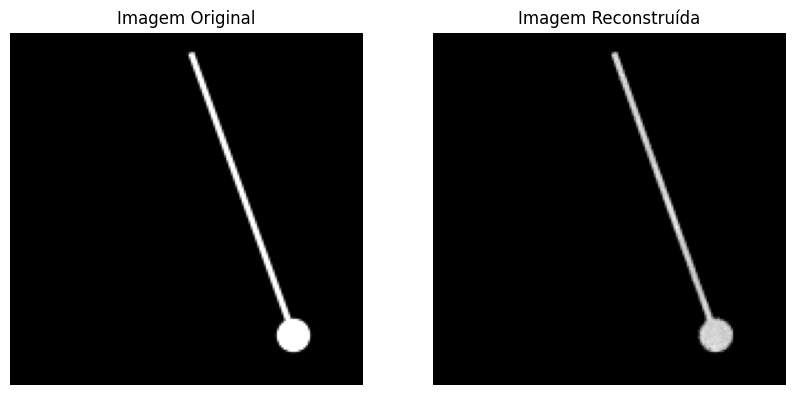

In [9]:
# Coloca o modelo em modo de avaliação
trainer.model.eval()

# Supondo que você quer testar com a primeira imagem do dataset de teste
dataiter = iter(trainer.test_dataloader)
images = next(dataiter)

# Executar a imagem pela rede
output, output2 = trainer.model(images[0].unsqueeze(0).to(trainer.dev))

# Converte a saída do modelo e a entrada para exibição
output = output.cpu().detach().numpy().squeeze()
input_image = images[0].cpu().detach().numpy().squeeze()

# Plotando as imagens
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(input_image, cmap='gray')
ax[0].set_title('Imagem Original')
ax[0].axis('off')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Imagem Reconstruída')
ax[1].axis('off')
plt.savefig("Imagem-Reconstruída",dpi=1000)
plt.show()


In [4]:
asas

NameError: name 'asas' is not defined

In [ ]:
time = np.linspace(0,2.1,100)
trainer.model.eval()  # Coloca o modelo em modo de avaliação
plt.figure(figsize=(10, 6))
for i, data in enumerate(trainer.test_dataloader, 0):
    data = data.to("cuda")  # Move data to GPU
    output,output2 = trainer.model(data)
    latente = output2.cpu().detach().numpy()

scatter = plt.scatter(latente[:, 0], latente[:, 1], c=time, cmap='jet', s=80, alpha=1.0, edgecolors='k')

# Adicionar colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Tempo (s)', rotation=270, labelpad=15)

# Definir título e labels
plt.title("Espaço Latente", fontsize=14)
plt.xlabel(r"$z_1$", fontsize=12)
plt.ylabel(r"$z_2$", fontsize=12)

# Adicionar grid
plt.grid(True)

# Mostrar o plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importar o módulo 3D

# Suponha que `time` já está definido e `trainer` já foi treinado

time = np.linspace(0, 2.1, 100)
trainer.model.eval()  # Coloca o modelo em modo de avaliação

for i, data in enumerate(trainer.test_dataloader, 0):
    data = data.to("cuda")  # Move data to GPU
    output, output2 = trainer.model(data)
    latente = output2.cpu().detach().numpy()

np.savetxt("lantentespace.txt",latente)

In [ ]:

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')  # Criar um subplot 3D
scatter = ax.scatter(latente[:, 0], latente[:, 1], time, c=time, cmap='jet', s=80, alpha=1.0, edgecolors='k')

# Adicionar colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Tempo (s)', rotation=270, labelpad=15)

# Definir título e labels
ax.set_title("Espaço Latente", fontsize=14)
ax.set_xlabel(r"$z_1$", fontsize=12)
ax.set_ylabel(r"$z_2$", fontsize=12)
ax.set_zlabel(r"$z_3$", fontsize=12)

# Adicionar grid
ax.grid(True)

# Mostrar o plot
plt.show()
